Self-Attention Generative Adversarial Network (SAGAN) allows attention-driven, long-range dependency modeling for image generation tasks. Traditional convolutional GANs generate high-resolution details as a function of only spatially local points in lower-resolution feature maps. In SAGAN, details can be generated using cues from all feature locations. Moreover, the discriminator can check that highly detailed features in distant portions of the image are consistent with each other.
<br><br>The self-attention module is complementary to convolutions and helps with modeling long range, multi-level dependencies across image regions. Armed with self-attention, the generator can draw images in which fine details at every location are carefully coordinated with fine details in distant portions of the image. Moreover, the discriminator can also more accurately enforce complicated geometric constraints on the global image structure. Visualization of the attention layers shows that the generator leverages neighborhoods that correspond to object shapes rather than local regions of fixed shape. 
<br><br>SAGAN achieves better Inception score, Intra FID score and FID score when compared with state-of-the-art GAN models.
<br>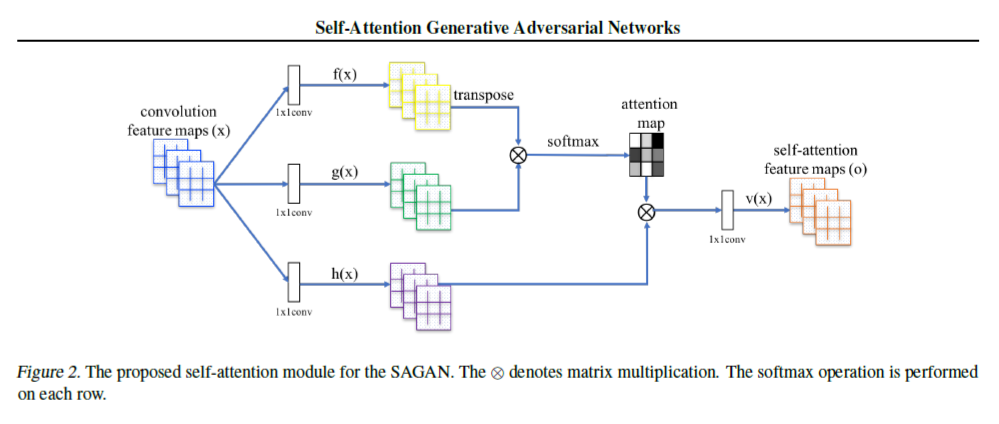

In [1]:
# This code implements the Self Attention module of SAGAN
import torch
import torch.nn as nn
import torch.nn.functional as F

In [34]:
class self_attn(nn.Module):
    
    def __init__(self, in_channels, attn_channels):
        super().__init__()
        self.f = nn.Conv2d(in_channels, attn_channels, kernel_size=1)
        self.g = nn.Conv2d(in_channels, attn_channels, kernel_size=1)
        self.h = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        batch_size, c, h, w = x.size()
        fx = self.f(x).view(batch_size, -1, h*w) # B x C` x N
        gx = self.g(x).view(batch_size, -1, h*w)
        fx = fx.permute(0,2,1)  # B x C` x N --> B x N x C` (Transposing) 
        attn_map = torch.bmm(fx, gx) # B x N x N
        attn_map_softmax = F.softmax(attn_map, dim = -1)  # softmax on each row
        hx = self.h(x).view(batch_size, c, h*w)
        self_attn_maps = torch.bmm(hx, attn_map_softmax.permute(0, 2, 1))
        self_attn_maps = self_attn_maps.view(batch_size, c, h, w)
        self_attn_maps = self.gamma*self_attn_maps + x
        return self_attn_maps, attn_map_softmax

In [35]:
x = torch.randn(10,32,128,128)
x.shape

torch.Size([10, 32, 128, 128])

In [36]:
model = self_attn(x.size(1), x.size(1)//8)

In [37]:
out = model(x)

In [38]:
out[0].shape

torch.Size([10, 32, 128, 128])

In [39]:
out[1].shape

torch.Size([10, 16384, 16384])

In [40]:
out[1]

tensor([[[7.6690e-05, 6.4023e-05, 1.1515e-04,  ..., 3.2851e-05,
          5.5114e-05, 5.2354e-05],
         [1.5655e-05, 5.6398e-05, 8.3437e-05,  ..., 4.1806e-05,
          6.5373e-05, 8.3425e-05],
         [3.9434e-05, 3.9381e-05, 1.8724e-05,  ..., 1.2470e-04,
          6.9735e-05, 5.4876e-05],
         ...,
         [1.8816e-05, 5.7452e-05, 6.8396e-05,  ..., 5.3364e-05,
          6.3452e-05, 7.6043e-05],
         [3.6898e-05, 4.5037e-05, 7.4936e-05,  ..., 4.6284e-05,
          7.4596e-05, 4.5398e-05],
         [4.0151e-05, 3.4568e-05, 1.2488e-05,  ..., 1.2989e-04,
          8.2750e-05, 8.6432e-05]],

        [[2.7764e-05, 1.6385e-05, 3.5527e-05,  ..., 2.8658e-05,
          6.4555e-05, 2.5851e-05],
         [2.8278e-05, 1.7265e-04, 1.1733e-04,  ..., 2.4693e-05,
          1.6283e-05, 2.3130e-04],
         [9.0271e-05, 7.1689e-05, 8.8137e-05,  ..., 1.4770e-04,
          2.4311e-05, 7.5353e-05],
         ...,
         [8.6008e-05, 6.7731e-05, 4.4261e-05,  ..., 1.0295e-04,
          6.504